An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be reversed, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.

Modified to train RNN to conjugate past tense of verbs. Data currently taken from UCLA dataset on verb conjugation.

Code taken, modified from https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [77]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import csv
from keras.regularizers import L1L2

## Character Table

Taking in our string of numbers/operations as a string of characters, we must vectorize each character as a new input to our RNN. 

We first create a table mapping each character in our vocabulary (in our case, this is the numbers 0-9 and addition symbol '+') to a unique integer index. We also create a table mapping back the other way. 

To encode a string, we convert each character in the string to a one-hot vector with the character index as 1 and all other indices as 0. We also feed in the parameter `num_rows` as a maximum length of our string, equivalent to padding all strings to a specified length.

To decode an output array x, we take each vector of the string (representing a component) and decode it back into its most likely character. NOTE: I'm a little unclear about how we deal with variable-length answers. Maybe those are just decoded into space characters?

In [78]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


In [79]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'


## Model Parameters

These parameters are now heuristically chosen based on the data in our database.

MAXLEN is the maximum length of any one input (or can be truncated below that). Chosen as 14, for max input length from UCLA dataset.  
TRAINING_SIZE is an approximation (I think) for the number of examples in our dataset.  
`chars` is a string with all characters that can be used in our inputs/outputs. We also add a space for padding.

REVERSE is not currently used, but it should indicate whether we feed the inputs in standard order or reversed.

In [80]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
MAXLEN_INPUT = 14
MAXLEN_OUTPUT = 15
REVERSE = True

chars = 'abcdefghijklmnopqrstuvwxyz '
ctable = CharacterTable(chars)


## Data Processing for Verb Tenses

We read in the data from our CSV of UCLA's verb tenses. Then we vectorize them using the Character class and model parameters defined above.

In [81]:
data_file = 'ucla-verb-tenses.csv'

import re # For stripping non-alphanumeric characters
present = []
past = []
with open(data_file) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        if not (re.search(r'\W+', row[0]) or re.search(r'\W+', row[1])):
            # Only add if all alphanumeric
            # Then pad inputs with spaces
            present_word = row[0] + ' ' * (MAXLEN_INPUT - len(row[0]))
            if REVERSE:
                # Reverse the query, e.g., '12+345  ' becomes '  543+21'.
                present_word = present_word[::-1]
            present.append(present_word)
            past_word = row[1] + ' ' * (MAXLEN_OUTPUT - len(row[1]))
            past.append(past_word)

print(list(zip(present, past))[:10])
print("MAXLEN of input: ", max([len(s) for s in present]))
print("MAXLEN of output: ", max([len(s) for s in past]))

assert(len(present)==len(past))
print("Num examples: ", len(present))

[('          teba', 'abetted        '), ('         ediba', 'abided         '), ('       hsiloba', 'abolished      '), ('        dnuoba', 'abounded       '), ('        tnesba', 'absented       '), ('        brosba', 'absorbed       '), ('      tcartsba', 'abstracted     '), ('         esuba', 'abused         '), ('    etarelecca', 'accelerated    '), ('        tpecca', 'accepted       ')]
MAXLEN of input:  14
MAXLEN of output:  15
Num examples:  2144


## Data Processing

Vectorize data using the Character library and previously set parameters

In [82]:
print('Vectorization...')
x = np.zeros((len(past), MAXLEN_INPUT, len(chars)), dtype=np.bool)
y = np.zeros((len(past), MAXLEN_OUTPUT, len(chars)), dtype=np.bool)
for i, word in enumerate(present):
    x[i] = ctable.encode(word, MAXLEN_INPUT)
for i, word in enumerate(past):
    y[i] = ctable.encode(word, MAXLEN_OUTPUT)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Vectorization...
Training Data:
(1930, 14, 27)
(1930, 15, 27)
Validation Data:
(214, 14, 27)
(214, 15, 27)


## Setting up Model

In [83]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 512
BATCH_SIZE = 128
LAYERS = 3


print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN_INPUT, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(MAXLEN_OUTPUT))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 128)               79872     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 15, 128)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 15, 128)           131584    
_________________________________________________________________
lstm_25 (LSTM)               (None, 15, 128)           131584    
_________________________________________________________________
lstm_26 (LSTM)               (None, 15, 128)           131584    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 27)            3483      
_________________________________________________________________
activation_10 (Activation)   (None, 15, 27)            0     

## Training, Validating Model

In [84]:
# Print validation examples and classifications from the dataset
def classify_val_examples():
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

#Takes list of past loss and val_loss values, plots them
def plot_learning_curves(loss, val_loss):
    pyplot.clf()
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()


--------------------------------------------------
Iteration 1
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 1.1656 - acc: 0.6479 - val_loss: 1.1968 - val_acc: 0.6358
Q relive         T relived         ☒ eeereed        
Q dilute         T diluted         ☒ eeereed        
Q journey        T journeyed       ☒ eeerited       
Q rule           T ruled           ☒ eeeed          
Q comb           T combed          ☒ eerted         
Q become         T became          ☒ eeereed        
Q glide          T glided          ☒ eeeeed         
Q venture        T ventured        ☒ eeerited       
Q depend         T depended        ☒ eeerteed       
Q skip           T skipped         ☒ eerted         

--------------------------------------------------
Iteration 2
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 1.1770 - acc: 0.6421 - val_loss: 1.1737 

Q quote          T quoted          ☒ eeeeed         

--------------------------------------------------
Iteration 11
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 1.1418 - acc: 0.6541 - val_loss: 1.1480 - val_acc: 0.6570
Q dangle         T dangled         ☒ eeaated        
Q hurl           T hurled          ☒ eoaled         
Q readjust       T readjusted      ☒ seeeriated     
Q flare          T flared          ☒ eeated         
Q redecorate     T redecorated     ☒ seeeeeeated    
Q readjust       T readjusted      ☒ seeeriated     
Q germinate      T germinated      ☒ seeeiiited     
Q foster         T fostered        ☒ eeeerted       
Q blunder        T blundered       ☒ seeeeated      
Q dart           T darted          ☒ eoaled         

--------------------------------------------------
Iteration 12
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1m

1930/1930 [==============================] - 2s 1ms/step - loss: 1.0702 - acc: 0.6784 - val_loss: 1.1100 - val_acc: 0.6682
Q date           T dated           ☒ eeeed          
Q mount          T mounted         ☒ sointed        
Q glower         T glowered        ☒ eeeeered       
Q flame          T flamed          ☒ eaated         
Q disarm         T disarmed        ☒ erriited       
Q manufacture    T manufactured    ☒ seeetttiated   
Q dilute         T diluted         ☒ eooated        
Q retort         T retorted        ☒ eeeeeted       
Q splash         T splashed        ☒ eoiineed       
Q state          T stated          ☒ eeated         

--------------------------------------------------
Iteration 22
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 2ms/step - loss: 1.0790 - acc: 0.6746 - val_loss: 1.1081 - val_acc: 0.6688
Q picture        T pictured        ☒ eeeeated       
Q believe        T believed        ☒ eeeered     

Q govern         T governed        ☒ serrored       

--------------------------------------------------
Iteration 31
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 1.0074 - acc: 0.7001 - val_loss: 1.0267 - val_acc: 0.6944
Q spray          T sprayed         ☒ srailed        
Q stand          T stood           ☒ seeated        
Q obscure        T obscured        ☒ seooored       
Q rival          T rivaled         ☒ srualed        
Q disarm         T disarmed        ☒ srrruled       
Q implement      T implemented     ☒ seettttated    
Q shrill         T shrilled        ☒ srrusled       
Q portray        T portrayed       ☒ serrrised      
Q skip           T skipped         ☒ saaped         
Q state          T stated          ☒ eaated         

--------------------------------------------------
Iteration 32
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1m

Q fill           T filled          ☒ sailed         
Q pervade        T pervaded        ☒ seeeeded       

--------------------------------------------------
Iteration 41
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.9448 - acc: 0.7172 - val_loss: 1.0062 - val_acc: 0.6950
Q excite         T excited         ☒ siiited        
Q obsess         T obsessed        ☒ serrrted       
Q heave          T heaved          ☒ eeeded         
Q ban            T banned          ☒ saped          
Q journey        T journeyed       ☒ seeeerted      
Q venture        T ventured        ☒ seeerred       
Q germinate      T germinated      ☒ settiaated     
Q comb           T combed          ☒ soused         
Q contain        T contained       ☒ setiiited      
Q sprint         T sprinted        ☒ setiited       

--------------------------------------------------
Iteration 42
Train on 1930 samples, validate on 214 samples
Epoch 1

Q shatter        T shattered       ☒ seeeeeered     
Q contradict     T contradicted    ☒ seenitiaated   
Q fill           T filled          ☒ slllhed        
Q brighten       T brightened      ☒ seenneeened    
Q comb           T combed          ☒ soushed        
Q mount          T mounted         ☒ sepoled        


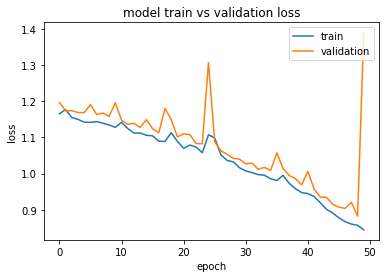


--------------------------------------------------
Iteration 51
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.9461 - acc: 0.7136 - val_loss: 0.9117 - val_acc: 0.7243
Q betide         T betided         ☒ seeeted        
Q germinate      T germinated      ☒ senttlated     
Q foster         T fostered        ☒ seeerred       
Q fashion        T fashioned       ☒ seooooned      
Q giggle         T giggled         ☒ sallled        
Q flame          T flamed          ☒ saamed         
Q shy            T shied           ☒ sased          
Q underscore     T underscored     ☒ seorrooored    
Q assume         T assumed         ☒ srossed        
Q terrify        T terrified       ☒ serrified      

--------------------------------------------------
Iteration 52
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.8519 - acc: 0.7446 - val_loss: 0.874

Q become         T became          ☒ sooomed        
Q awake          T awoke           ☒ cacked         
Q collar         T collared        ☒ srrlaled       
Q grunt          T grunted         ☒ sounted        
Q alienate       T alienated       ☒ senttated      

--------------------------------------------------
Iteration 61
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.7547 - acc: 0.7737 - val_loss: 0.7816 - val_acc: 0.7713
Q comb           T combed          ☒ souped         
Q lengthen       T lengthened      ☒ senneeened     
Q slant          T slanted         ☑ slanted        
Q underscore     T underscored     ☒ serrrrrered    
Q ponder         T pondered        ☒ seeeered       
Q quote          T quoted          ☒ sooted         
Q backstitch     T backstitched    ☒ sainiitcated   
Q forsake        T forsook         ☒ srracked       
Q demand         T demanded        ☒ senanded       
Q depend     

1930/1930 [==============================] - 3s 1ms/step - loss: 0.6877 - acc: 0.7939 - val_loss: 0.7273 - val_acc: 0.7854
Q depend         T depended        ☒ senended       
Q admonish       T admonished      ☒ sinsiished     
Q blossom        T blossomed       ☒ soopoosed      
Q hurl           T hurled          ☒ sorled         
Q test           T tested          ☒ sested         
Q direct         T directed        ☒ setected       
Q become         T became          ☒ sopumed        
Q erupt          T erupted         ☒ soumted        
Q slant          T slanted         ☑ slanted        
Q officiate      T officiated      ☒ siiiiiated     

--------------------------------------------------
Iteration 71
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 2ms/step - loss: 0.6794 - acc: 0.7952 - val_loss: 0.7262 - val_acc: 0.7835
Q distract       T distracted      ☒ sertracted     
Q spell          T spelled         ☒ seelled     

Q avail          T availed         ☒ seained        
Q slant          T slanted         ☑ slanted        
Q dart           T darted          ☒ rarted         
Q relive         T relived         ☒ sevived        
Q complete       T completed       ☒ sommpeled      

--------------------------------------------------
Iteration 80
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.6215 - acc: 0.8117 - val_loss: 0.6805 - val_acc: 0.7925
Q brighten       T brightened      ☒ ciiitteled     
Q slant          T slanted         ☑ slanted        
Q reside         T resided         ☒ sefided        
Q shrill         T shrilled        ☒ slrilled       
Q acquiesce      T acquiesced      ☒ sinsiiiced     
Q convene        T convened        ☒ sonvened       
Q dangle         T dangled         ☒ slngled        
Q evoke          T evoked          ☒ shoked         
Q relive         T relived         ☒ seeited        
Q avenge     

1930/1930 [==============================] - 3s 1ms/step - loss: 0.5672 - acc: 0.8270 - val_loss: 0.6357 - val_acc: 0.8103
Q underscore     T underscored     ☒ corrsroored    
Q stack          T stacked         ☑ stacked        
Q spread         T spread          ☒ segdad         
Q contact        T contacted       ☒ snttacted      
Q picture        T pictured        ☒ soctured       
Q heave          T heaved          ☒ seaved         
Q narrow         T narrowed        ☒ crrrowed       
Q deduce         T deduced         ☒ secuced        
Q emulate        T emulated        ☒ slllated       
Q quote          T quoted          ☒ bouted         

--------------------------------------------------
Iteration 90
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.5503 - acc: 0.8316 - val_loss: 0.6320 - val_acc: 0.8121
Q heat           T heated          ☒ seated         
Q construe       T construed       ☒ sonttored   

Q amount         T amounted        ☒ soounted       

--------------------------------------------------
Iteration 99
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.5217 - acc: 0.8385 - val_loss: 0.6217 - val_acc: 0.8106
Q groan          T groaned         ☒ drrarned       
Q date           T dated           ☒ aaded          
Q direct         T directed        ☒ aiteched       
Q demand         T demanded        ☒ eedaaded       
Q spread         T spread          ☒ seggad         
Q own            T owned           ☒ wowed          
Q inform         T informed        ☒ sofoomed       
Q obscure        T obscured        ☒ coccured       
Q implement      T implemented     ☒ copmmpented    
Q interrupt      T interrupted     ☒ cererrribed    

--------------------------------------------------
Iteration 100
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1

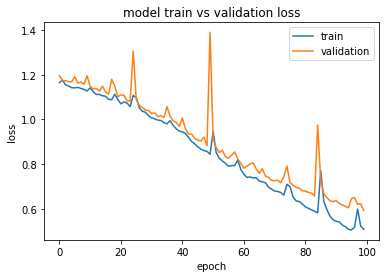


--------------------------------------------------
Iteration 101
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.4793 - acc: 0.8530 - val_loss: 0.5787 - val_acc: 0.8249
Q fashion        T fashioned       ☒ cossooned      
Q collar         T collared        ☒ clllared       
Q distinguish    T distinguished   ☒ cinsssihished  
Q distinguish    T distinguished   ☒ cinsssihished  
Q glide          T glided          ☒ bladed         
Q interrupt      T interrupted     ☒ ceeerrribed    
Q paralyze       T paralyzed       ☒ aaallized      
Q bogey          T bogeyed         ☒ pleeded        
Q reject         T rejected        ☒ eejected       
Q die            T died            ☒ dded           

--------------------------------------------------
Iteration 102
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.4676 - acc: 0.8565 - val_loss: 0.5

Q reward         T rewarded        ☒ rrrarded       
Q ban            T banned          ☑ banned         

--------------------------------------------------
Iteration 111
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.4007 - acc: 0.8771 - val_loss: 0.5274 - val_acc: 0.8396
Q skip           T skipped         ☒ ssipped        
Q reward         T rewarded        ☒ rrrarded       
Q invent         T invented        ☑ invented       
Q weigh          T weighed         ☒ shighed        
Q preach         T preached        ☒ perached       
Q plug           T plugged         ☑ plugged        
Q converge       T converged       ☒ cnnvvrred      
Q display        T displayed       ☒ sespllied      
Q experiment     T experimented    ☒ crreepppated   
Q expect         T expected        ☒ eepected       

--------------------------------------------------
Iteration 112
Train on 1930 samples, validate on 214 samples
Epoch

Q regard         T regarded        ☒ eegarded       

--------------------------------------------------
Iteration 121
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.3277 - acc: 0.8985 - val_loss: 0.4617 - val_acc: 0.8611
Q place          T placed          ☑ placed         
Q please         T pleased         ☒ ppeased        
Q agree          T agreed          ☒ raked          
Q foster         T fostered        ☒ costered       
Q govern         T governed        ☒ coverned       
Q paralyze       T paralyzed       ☒ aaallized      
Q enforce        T enforced        ☒ ennorced       
Q mobilize       T mobilized       ☒ pommlized      
Q reckon         T reckoned        ☒ resconed       
Q tighten        T tightened       ☒ aiahtened      

--------------------------------------------------
Iteration 122
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 

Q misuse         T misused         ☒ iupiseed       

--------------------------------------------------
Iteration 131
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.4484 - acc: 0.8561 - val_loss: 0.4697 - val_acc: 0.8517
Q trudge         T trudged         ☒ trugged        
Q alienate       T alienated       ☒ allinnted      
Q pin            T pinned          ☑ pinned         
Q amount         T amounted        ☒ roounted       
Q retort         T retorted        ☑ retorted       
Q demand         T demanded        ☒ denaned        
Q bribe          T bribed          ☑ bribed         
Q terrify        T terrified       ☒ rerrified      
Q tie            T tied            ☒ tid            
Q advance        T advanced        ☒ aaaacced       

--------------------------------------------------
Iteration 132
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 

Q shy            T shied           ☒ set            
Q loom           T loomed          ☑ loomed         
Q obsess         T obsessed        ☒ posessed       
Q act            T acted           ☒ aated          
Q enslave        T enslaved        ☑ enslaved       

--------------------------------------------------
Iteration 141
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 2ms/step - loss: 0.1870 - acc: 0.9477 - val_loss: 0.3753 - val_acc: 0.8829
Q groan          T groaned         ☒ graaned        
Q expand         T expanded        ☒ expanne        
Q brag           T bragged         ☑ bragged        
Q rid            T rid             ☒ rided          
Q advance        T advanced        ☒ aaaacced       
Q rape           T raped           ☑ raped          
Q flare          T flared          ☑ flared         
Q grimace        T grimaced        ☒ ariiited       
Q emulate        T emulated        ☑ emulated       
Q lead      

1930/1930 [==============================] - 2s 1ms/step - loss: 0.1855 - acc: 0.9449 - val_loss: 0.3479 - val_acc: 0.8960
Q place          T placed          ☑ placed         
Q reside         T resided         ☑ resided        
Q disturb        T disturbed       ☒ iistuubed      
Q avenge         T avenged         ☒ dvended        
Q comb           T combed          ☒ comped         
Q spell          T spelled         ☑ spelled        
Q reward         T rewarded        ☒ rrrarded       
Q dissuade       T dissuaded       ☒ dsssuided      
Q converge       T converged       ☒ conceared      
Q shatter        T shattered       ☑ shattered      


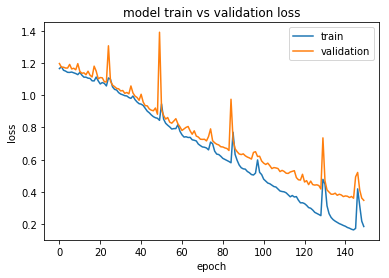


--------------------------------------------------
Iteration 151
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.1652 - acc: 0.9524 - val_loss: 0.3448 - val_acc: 0.8928
Q reckon         T reckoned        ☑ reckoned       
Q paralyze       T paralyzed       ☒ baaalized      
Q reject         T rejected        ☑ rejected       
Q fill           T filled          ☑ filled         
Q shatter        T shattered       ☑ shattered      
Q lead           T led             ☒ leaded         
Q recall         T recalled        ☒ reralled       
Q smother        T smothered       ☒ sosttered      
Q hand           T handed          ☑ handed         
Q ban            T banned          ☑ banned         

--------------------------------------------------
Iteration 152
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.1517 - acc: 0.9597 - val_loss: 0.3

1930/1930 [==============================] - 3s 1ms/step - loss: 0.1030 - acc: 0.9753 - val_loss: 0.3209 - val_acc: 0.9093
Q invent         T invented        ☑ invented       
Q groan          T groaned         ☑ groaned        
Q mount          T mounted         ☑ mounted        
Q retort         T retorted        ☑ retorted       
Q readjust       T readjusted      ☒ reaoousted     
Q tie            T tied            ☑ tied           
Q counsel        T counseled       ☒ cooseeled      
Q terrify        T terrified       ☑ terrified      
Q spray          T sprayed         ☒ spaamed        
Q enforce        T enforced        ☑ enforced       

--------------------------------------------------
Iteration 162
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.1000 - acc: 0.9763 - val_loss: 0.3241 - val_acc: 0.9072
Q retort         T retorted        ☑ retorted       
Q quote          T quoted          ☒ juuted     

Q nail           T nailed          ☒ nuiled         
Q damn           T damned          ☒ dained         

--------------------------------------------------
Iteration 171
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0736 - acc: 0.9847 - val_loss: 0.3161 - val_acc: 0.9112
Q dismiss        T dismissed       ☒ dismmssed      
Q blunder        T blundered       ☒ buundered      
Q flare          T flared          ☑ flared         
Q shrill         T shrilled        ☑ shrilled       
Q expand         T expanded        ☒ expanned       
Q believe        T believed        ☒ besveded       
Q respond        T responded       ☑ responded      
Q please         T pleased         ☒ peeased        
Q complete       T completed       ☒ comppelled     
Q blossom        T blossomed       ☒ boossosed      

--------------------------------------------------
Iteration 172
Train on 1930 samples, validate on 214 samples
Epoch

Q contain        T contained       ☑ contained      

--------------------------------------------------
Iteration 181
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.1162 - acc: 0.9672 - val_loss: 0.2965 - val_acc: 0.9143
Q focus          T focused         ☑ focused        
Q invent         T invented        ☑ invented       
Q fashion        T fashioned       ☒ sashioned      
Q engender       T engendered      ☒ exgendered     
Q acquiesce      T acquiesced      ☒ acquuicted     
Q approximate    T approximated    ☒ spprrpmiated   
Q heat           T heated          ☑ heated         
Q brighten       T brightened      ☒ brrghtened     
Q alienate       T alienated       ☒ allenated      
Q misuse         T misused         ☒ misised        

--------------------------------------------------
Iteration 182
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 

1930/1930 [==============================] - 2s 1ms/step - loss: 0.0454 - acc: 0.9933 - val_loss: 0.2826 - val_acc: 0.9187
Q shrill         T shrilled        ☑ shrilled       
Q inform         T informed        ☑ informed       
Q rival          T rivaled         ☒ rttaled        
Q grimace        T grimaced        ☒ grrmiced       
Q nail           T nailed          ☒ nuiled         
Q flutter        T fluttered       ☒ fllttered      
Q direct         T directed        ☒ diiected       
Q counsel        T counseled       ☒ cousseled      
Q lodge          T lodged          ☑ lodged         
Q distract       T distracted      ☑ distracted     

--------------------------------------------------
Iteration 192
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0435 - acc: 0.9932 - val_loss: 0.2838 - val_acc: 0.9171
Q smother        T smothered       ☒ spottered      
Q amount         T amounted        ☑ amounted   

Q invent         T invented        ☑ invented       


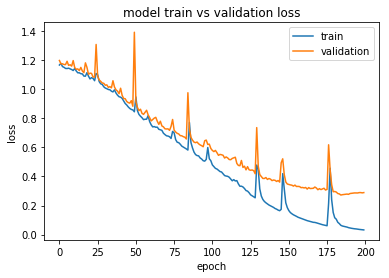


--------------------------------------------------
Iteration 201
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0317 - acc: 0.9964 - val_loss: 0.2898 - val_acc: 0.9212
Q demoralize     T demoralized     ☒ demomalized    
Q patronize      T patronized      ☒ partaiized     
Q obsess         T obsessed        ☑ obsessed       
Q blossom        T blossomed       ☒ boosfosed      
Q direct         T directed        ☒ diiected       
Q institute      T instituted      ☒ insiituted     
Q boot           T booted          ☑ booted         
Q worry          T worried         ☑ worried        
Q misuse         T misused         ☒ misssed        
Q shy            T shied           ☒ set            

--------------------------------------------------
Iteration 202
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0316 - acc: 0.9965 - val_loss: 0.2

Q flare          T flared          ☑ flared         
Q flame          T flamed          ☑ flamed         

--------------------------------------------------
Iteration 211
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.0232 - acc: 0.9981 - val_loss: 0.2948 - val_acc: 0.9209
Q forsake        T forsook         ☒ forcoked       
Q preach         T preached        ☑ preached       
Q want           T wanted          ☒ wanned         
Q assume         T assumed         ☒ assumme        
Q focus          T focused         ☒ fofused        
Q boot           T booted          ☑ booted         
Q assess         T assessed        ☑ assessed       
Q construe       T construed       ☒ constored      
Q believe        T believed        ☒ belieded       
Q admit          T admitted        ☑ admitted       

--------------------------------------------------
Iteration 212
Train on 1930 samples, validate on 214 samples
Epoch

Q comb           T combed          ☒ comped         

--------------------------------------------------
Iteration 221
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0174 - acc: 0.9988 - val_loss: 0.2961 - val_acc: 0.9265
Q alienate       T alienated       ☒ allnnited      
Q nail           T nailed          ☒ nuiled         
Q stack          T stacked         ☑ stacked        
Q bloom          T bloomed         ☑ bloomed        
Q date           T dated           ☑ dated          
Q govern         T governed        ☑ governed       
Q enslave        T enslaved        ☒ ensloved       
Q grunt          T grunted         ☑ grunted        
Q reject         T rejected        ☑ rejected       
Q reject         T rejected        ☑ rejected       

--------------------------------------------------
Iteration 222
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 

Q distract       T distracted      ☑ distracted     

--------------------------------------------------
Iteration 231
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0131 - acc: 0.9994 - val_loss: 0.2990 - val_acc: 0.9246
Q boot           T booted          ☑ booted         
Q engender       T engendered      ☑ engendered     
Q redecorate     T redecorated     ☒ redeccrated    
Q mobilize       T mobilized       ☒ mobllized      
Q tie            T tied            ☒ toed           
Q sweep          T swept           ☒ swep           
Q coordinate     T coordinated     ☒ cooudinated    
Q panic          T panicked        ☒ paaiced        
Q govern         T governed        ☑ governed       
Q contain        T contained       ☑ contained      

--------------------------------------------------
Iteration 232
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 

Q readjust       T readjusted      ☑ readjusted     
Q foster         T fostered        ☑ fostered       
Q pin            T pinned          ☑ pinned         
Q expand         T expanded        ☒ expanned       

--------------------------------------------------
Iteration 241
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.0234 - acc: 0.9974 - val_loss: 0.2730 - val_acc: 0.9265
Q dress          T dressed         ☒ deessed        
Q flare          T flared          ☑ flared         
Q forsake        T forsook         ☒ forvaked       
Q spell          T spelled         ☑ spelled        
Q ban            T banned          ☑ banned         
Q reside         T resided         ☑ resided        
Q advance        T advanced        ☒ aavanced       
Q excite         T excited         ☑ excited        
Q dazzle         T dazzled         ☒ dazzzed        
Q bogey          T bogeyed         ☒ bogeded        

-----------

1930/1930 [==============================] - 3s 2ms/step - loss: 0.0111 - acc: 0.9996 - val_loss: 0.2780 - val_acc: 0.9324
Q use            T used            ☑ used           
Q contact        T contacted       ☑ contacted      
Q dissuade       T dissuaded       ☒ disfuuded      
Q depend         T depended        ☑ depended       
Q grimace        T grimaced        ☒ gramited       
Q panic          T panicked        ☒ paained        
Q deduce         T deduced         ☑ deduced        
Q track          T tracked         ☑ tracked        
Q revive         T revived         ☑ revived        
Q paralyze       T paralyzed       ☒ paaalized      


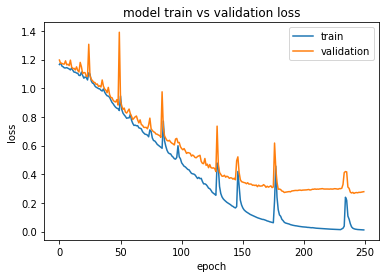


--------------------------------------------------
Iteration 251
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.0107 - acc: 0.9996 - val_loss: 0.2774 - val_acc: 0.9305
Q stack          T stacked         ☑ stacked        
Q brag           T bragged         ☑ bragged        
Q agree          T agreed          ☒ aaked          
Q slacken        T slackened       ☒ slankened      
Q venture        T ventured        ☒ vevtured       
Q find           T found           ☒ finded         
Q institute      T instituted      ☒ instttuted     
Q preach         T preached        ☑ preached       
Q relive         T relived         ☒ relited        
Q underscore     T underscored     ☒ undercooced    

--------------------------------------------------
Iteration 252
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.0102 - acc: 0.9997 - val_loss: 0.2

Q obscure        T obscured        ☒ oescured       

--------------------------------------------------
Iteration 261
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0078 - acc: 0.9997 - val_loss: 0.2850 - val_acc: 0.9327
Q hurl           T hurled          ☑ hurled         
Q germinate      T germinated      ☒ geriinated     
Q sweep          T swept           ☑ swept          
Q use            T used            ☑ used           
Q jab            T jabbed          ☒ japged         
Q tighten        T tightened       ☑ tightened      
Q germinate      T germinated      ☒ geriinated     
Q dangle         T dangled         ☒ dnngged        
Q focus          T focused         ☒ fofused        
Q damn           T damned          ☒ dained         

--------------------------------------------------
Iteration 262
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 

Q invent         T invented        ☑ invented       
Q test           T tested          ☑ tested         
Q stream         T streamed        ☑ streamed       
Q reckon         T reckoned        ☒ rechoned       
Q inform         T informed        ☑ informed       
Q dominate       T dominated       ☑ dominated      
Q loom           T loomed          ☑ loomed         

--------------------------------------------------
Iteration 271
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.0062 - acc: 0.9996 - val_loss: 0.2891 - val_acc: 0.9321
Q dangle         T dangled         ☒ dangged        
Q govern         T governed        ☑ governed       
Q use            T used            ☑ used           
Q find           T found           ☒ finded         
Q hitch          T hitched         ☑ hitched        
Q expand         T expanded        ☒ expanned       
Q rid            T rid             ☒ rode           
Q terrify   

1930/1930 [==============================] - 3s 1ms/step - loss: 0.0053 - acc: 0.9998 - val_loss: 0.2947 - val_acc: 0.9324
Q distract       T distracted      ☑ distracted     
Q complement     T complemented    ☒ compllteated   
Q heave          T heaved          ☒ heate          
Q manufacture    T manufactured    ☒ mannnnsuured   
Q engender       T engendered      ☑ engendered     
Q implement      T implemented     ☒ impllmented    
Q grunt          T grunted         ☑ grunted        
Q bay            T bayed           ☒ baed           
Q dress          T dressed         ☒ deessed        
Q test           T tested          ☑ tested         

--------------------------------------------------
Iteration 281
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 2ms/step - loss: 0.0052 - acc: 0.9998 - val_loss: 0.2943 - val_acc: 0.9315
Q expect         T expected        ☑ expected       
Q narrow         T narrowed        ☒ aarrewed   

Q own            T owned           ☑ owned          
Q rape           T raped           ☑ raped          

--------------------------------------------------
Iteration 290
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.0044 - acc: 0.9996 - val_loss: 0.2969 - val_acc: 0.9324
Q preach         T preached        ☑ preached       
Q rival          T rivaled         ☒ riticed        
Q portray        T portrayed       ☒ portrated      
Q explore        T explored        ☑ explored       
Q core           T cored           ☑ cored          
Q weigh          T weighed         ☒ wrighed        
Q forsake        T forsook         ☒ forcoked       
Q suffer         T suffered        ☑ suffered       
Q brag           T bragged         ☑ bragged        
Q regard         T regarded        ☑ regarded       

--------------------------------------------------
Iteration 291
Train on 1930 samples, validate on 214 samples
Epoch

Q recall         T recalled        ☑ recalled       

--------------------------------------------------
Iteration 300
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0038 - acc: 0.9998 - val_loss: 0.3015 - val_acc: 0.9330
Q suffer         T suffered        ☑ suffered       
Q believe        T believed        ☒ belieded       
Q orient         T oriented        ☒ ortented       
Q bay            T bayed           ☒ baed           
Q remove         T removed         ☒ remomed        
Q lengthen       T lengthened      ☒ lunhteened     
Q tolerate       T tolerated       ☒ telorated      
Q become         T became          ☒ becamed        
Q die            T died            ☒ die            
Q grunt          T grunted         ☑ grunted        


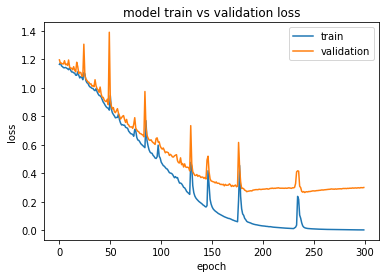


--------------------------------------------------
Iteration 301
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0038 - acc: 0.9997 - val_loss: 0.3018 - val_acc: 0.9336
Q believe        T believed        ☒ belieded       
Q smother        T smothered       ☒ smottered      
Q spell          T spelled         ☑ spelled        
Q narrow         T narrowed        ☒ aarrewed       
Q shatter        T shattered       ☑ shattered      
Q paralyze       T paralyzed       ☒ paaalized      
Q implement      T implemented     ☒ impllmented    
Q spell          T spelled         ☑ spelled        
Q stack          T stacked         ☑ stacked        
Q readjust       T readjusted      ☑ readjusted     

--------------------------------------------------
Iteration 302
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0037 - acc: 0.9998 - val_loss: 0.3

Q reward         T rewarded        ☒ relarded       
Q pervade        T pervaded        ☑ pervaded       

--------------------------------------------------
Iteration 311
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 2s 1ms/step - loss: 0.0033 - acc: 0.9997 - val_loss: 0.3041 - val_acc: 0.9330
Q forsake        T forsook         ☒ forcoked       
Q spray          T sprayed         ☑ sprayed        
Q narrow         T narrowed        ☒ aarrewed       
Q fashion        T fashioned       ☑ fashioned      
Q end            T ended           ☒ end            
Q disarm         T disarmed        ☒ disarsed       
Q thicken        T thickened       ☑ thickened      
Q alter          T altered         ☑ altered        
Q grunt          T grunted         ☑ grunted        
Q hurl           T hurled          ☑ hurled         

--------------------------------------------------
Iteration 312
Train on 1930 samples, validate on 214 samples
Epoch

Q pursue         T pursued         ☒ puruved        

--------------------------------------------------
Iteration 321
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 1ms/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.3078 - val_acc: 0.9355
Q weigh          T weighed         ☑ weighed        
Q disarm         T disarmed        ☒ disarsed       
Q lodge          T lodged          ☑ lodged         
Q warn           T warned          ☑ warned         
Q spell          T spelled         ☑ spelled        
Q contradict     T contradicted    ☒ contutiiated   
Q bogey          T bogeyed         ☒ bogeded        
Q grunt          T grunted         ☑ grunted        
Q foster         T fostered        ☑ fostered       
Q reassemble     T reassembled     ☒ retesspbled    

--------------------------------------------------
Iteration 322
Train on 1930 samples, validate on 214 samples
Epoch 1/1
1930/1930 [==============================] - 3s 

KeyboardInterrupt: 

In [88]:
# Train the model each generation and show predictions against the validation
# dataset. Also graph the loss and validation loss.

loss = []
val_loss = []
for iteration in range(1, 500):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    if iteration % 1 == 0:
        classify_val_examples()
    if iteration % 50 == 0:
        plot_learning_curves(loss, val_loss)
    
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

## Assessing Underfitting, Overfitting

Here we plot the model's results to diagnose underfitting or overfitting.

We'll plot the learning curves with training loss and validation loss to understand what happens. Machine Learning Yearning might help us understand this too.

In [66]:
%matplotlib inline
from matplotlib import pyplot

history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=600,
              validation_data=(x_val, y_val))
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

Train on 1930 samples, validate on 214 samples
Epoch 1/600
1930/1930 [==============================] - 3s 2ms/step - loss: 16.2367 - acc: 0.4288 - val_loss: 13.1607 - val_acc: 0.5012
Epoch 2/600
1930/1930 [==============================] - 1s 615us/step - loss: 11.3721 - acc: 0.4943 - val_loss: 9.2820 - val_acc: 0.5012
Epoch 3/600
1930/1930 [==============================] - 1s 660us/step - loss: 7.9315 - acc: 0.5038 - val_loss: 6.3251 - val_acc: 0.5274
Epoch 4/600
1930/1930 [==============================] - 1s 617us/step - loss: 5.3043 - acc: 0.5392 - val_loss: 4.1224 - val_acc: 0.5757
Epoch 5/600
1930/1930 [==============================] - 1s 667us/step - loss: 3.4177 - acc: 0.5678 - val_loss: 2.6190 - val_acc: 0.5732
Epoch 6/600
1930/1930 [==============================] - 1s 621us/step - loss: 2.2065 - acc: 0.5794 - val_loss: 1.7840 - val_acc: 0.5819
Epoch 7/600
1930/1930 [==============================] - 1s 609us/step - loss: 1.6438 - acc: 0.5798 - val_loss: 1.5287 - val_acc: 

1930/1930 [==============================] - 1s 589us/step - loss: 1.2479 - acc: 0.6424 - val_loss: 1.3026 - val_acc: 0.6059
Epoch 61/600
1930/1930 [==============================] - 1s 658us/step - loss: 1.2657 - acc: 0.6327 - val_loss: 1.2475 - val_acc: 0.6293
Epoch 62/600
1930/1930 [==============================] - 1s 682us/step - loss: 1.2452 - acc: 0.6430 - val_loss: 1.2669 - val_acc: 0.6274
Epoch 63/600
1930/1930 [==============================] - 1s 713us/step - loss: 1.2403 - acc: 0.6461 - val_loss: 1.2296 - val_acc: 0.6436
Epoch 64/600
1930/1930 [==============================] - 1s 713us/step - loss: 1.2300 - acc: 0.6527 - val_loss: 1.2156 - val_acc: 0.6592
Epoch 65/600
1930/1930 [==============================] - 1s 703us/step - loss: 1.2233 - acc: 0.6529 - val_loss: 1.2466 - val_acc: 0.6308
Epoch 66/600
1930/1930 [==============================] - 1s 687us/step - loss: 1.2351 - acc: 0.6473 - val_loss: 1.2176 - val_acc: 0.6498
Epoch 67/600
1930/1930 [=======================

1930/1930 [==============================] - 1s 573us/step - loss: 1.1067 - acc: 0.6840 - val_loss: 1.0962 - val_acc: 0.6879
Epoch 120/600
1930/1930 [==============================] - 1s 572us/step - loss: 1.1007 - acc: 0.6862 - val_loss: 1.1137 - val_acc: 0.6854
Epoch 121/600
1930/1930 [==============================] - 1s 572us/step - loss: 1.1091 - acc: 0.6839 - val_loss: 1.0905 - val_acc: 0.6850
Epoch 122/600
1930/1930 [==============================] - 1s 572us/step - loss: 1.0993 - acc: 0.6856 - val_loss: 1.0889 - val_acc: 0.6888
Epoch 123/600
1930/1930 [==============================] - 1s 575us/step - loss: 1.0974 - acc: 0.6877 - val_loss: 1.0866 - val_acc: 0.6882
Epoch 124/600
1930/1930 [==============================] - 1s 589us/step - loss: 1.0952 - acc: 0.6888 - val_loss: 1.0833 - val_acc: 0.6894
Epoch 125/600
1930/1930 [==============================] - 1s 581us/step - loss: 1.0941 - acc: 0.6881 - val_loss: 1.0956 - val_acc: 0.6841
Epoch 126/600
1930/1930 [================

1930/1930 [==============================] - 1s 575us/step - loss: 1.0149 - acc: 0.7060 - val_loss: 1.0364 - val_acc: 0.7016
Epoch 179/600
1930/1930 [==============================] - 1s 586us/step - loss: 1.0168 - acc: 0.7062 - val_loss: 1.0164 - val_acc: 0.7047
Epoch 180/600
1930/1930 [==============================] - 1s 587us/step - loss: 1.0034 - acc: 0.7087 - val_loss: 1.0323 - val_acc: 0.7016
Epoch 181/600
1930/1930 [==============================] - 1s 586us/step - loss: 1.0318 - acc: 0.7014 - val_loss: 1.1364 - val_acc: 0.6798
Epoch 182/600
1930/1930 [==============================] - 1s 575us/step - loss: 1.1142 - acc: 0.6820 - val_loss: 1.0871 - val_acc: 0.6916
Epoch 183/600
1930/1930 [==============================] - 1s 570us/step - loss: 1.0476 - acc: 0.6989 - val_loss: 1.0341 - val_acc: 0.7022
Epoch 184/600
1930/1930 [==============================] - 1s 570us/step - loss: 1.0126 - acc: 0.7062 - val_loss: 1.0250 - val_acc: 0.7019
Epoch 185/600
1930/1930 [================

1930/1930 [==============================] - 1s 589us/step - loss: 0.9506 - acc: 0.7244 - val_loss: 0.9825 - val_acc: 0.7156
Epoch 238/600
1930/1930 [==============================] - 1s 573us/step - loss: 0.9435 - acc: 0.7268 - val_loss: 0.9664 - val_acc: 0.7206
Epoch 239/600
1930/1930 [==============================] - 1s 575us/step - loss: 0.9297 - acc: 0.7297 - val_loss: 0.9660 - val_acc: 0.7206
Epoch 240/600
1930/1930 [==============================] - 1s 573us/step - loss: 0.9312 - acc: 0.7285 - val_loss: 0.9967 - val_acc: 0.7115
Epoch 241/600
1930/1930 [==============================] - 1s 589us/step - loss: 0.9388 - acc: 0.7288 - val_loss: 0.9724 - val_acc: 0.7206
Epoch 242/600
1930/1930 [==============================] - 1s 595us/step - loss: 0.9280 - acc: 0.7304 - val_loss: 0.9679 - val_acc: 0.7218
Epoch 243/600
1930/1930 [==============================] - 1s 576us/step - loss: 0.9231 - acc: 0.7318 - val_loss: 0.9621 - val_acc: 0.7237
Epoch 244/600
1930/1930 [================

1930/1930 [==============================] - 1s 572us/step - loss: 0.8467 - acc: 0.7583 - val_loss: 0.9201 - val_acc: 0.7364
Epoch 297/600
1930/1930 [==============================] - 1s 570us/step - loss: 0.8371 - acc: 0.7613 - val_loss: 0.9301 - val_acc: 0.7368
Epoch 298/600
1930/1930 [==============================] - 1s 576us/step - loss: 0.8330 - acc: 0.7630 - val_loss: 0.9332 - val_acc: 0.7312
Epoch 299/600
1930/1930 [==============================] - 1s 575us/step - loss: 0.8352 - acc: 0.7637 - val_loss: 0.9068 - val_acc: 0.7439
Epoch 300/600
1930/1930 [==============================] - 1s 589us/step - loss: 0.8238 - acc: 0.7656 - val_loss: 0.9358 - val_acc: 0.7346
Epoch 301/600
1930/1930 [==============================] - 1s 574us/step - loss: 0.8528 - acc: 0.7554 - val_loss: 0.9123 - val_acc: 0.7389
Epoch 302/600
1930/1930 [==============================] - 1s 571us/step - loss: 0.8414 - acc: 0.7589 - val_loss: 0.9292 - val_acc: 0.7389
Epoch 303/600
1930/1930 [================

1930/1930 [==============================] - 1s 667us/step - loss: 0.7701 - acc: 0.7845 - val_loss: 0.8956 - val_acc: 0.7517
Epoch 356/600
1930/1930 [==============================] - 1s 662us/step - loss: 0.7391 - acc: 0.7935 - val_loss: 0.8583 - val_acc: 0.7611
Epoch 357/600
1930/1930 [==============================] - 1s 689us/step - loss: 0.7336 - acc: 0.7937 - val_loss: 0.8610 - val_acc: 0.7607
Epoch 358/600
1930/1930 [==============================] - 1s 624us/step - loss: 0.7189 - acc: 0.8004 - val_loss: 0.8520 - val_acc: 0.7626
Epoch 359/600
1930/1930 [==============================] - 1s 639us/step - loss: 0.7128 - acc: 0.8014 - val_loss: 0.8641 - val_acc: 0.7570
Epoch 360/600
1930/1930 [==============================] - 1s 711us/step - loss: 0.7169 - acc: 0.8000 - val_loss: 0.8660 - val_acc: 0.7579
Epoch 361/600
1930/1930 [==============================] - 1s 710us/step - loss: 0.7030 - acc: 0.8044 - val_loss: 0.8365 - val_acc: 0.7673
Epoch 362/600
1930/1930 [================

1930/1930 [==============================] - 1s 613us/step - loss: 0.6815 - acc: 0.8117 - val_loss: 0.9299 - val_acc: 0.7474
Epoch 415/600
1930/1930 [==============================] - 1s 610us/step - loss: 0.7463 - acc: 0.7960 - val_loss: 0.8846 - val_acc: 0.7601
Epoch 416/600
1930/1930 [==============================] - 1s 623us/step - loss: 0.6482 - acc: 0.8249 - val_loss: 0.8379 - val_acc: 0.7692
Epoch 417/600
1930/1930 [==============================] - 1s 675us/step - loss: 0.6199 - acc: 0.8314 - val_loss: 0.8229 - val_acc: 0.7757
Epoch 418/600
1930/1930 [==============================] - 1s 618us/step - loss: 0.5880 - acc: 0.8393 - val_loss: 0.8267 - val_acc: 0.7701
Epoch 419/600
1930/1930 [==============================] - 1s 622us/step - loss: 0.5880 - acc: 0.8398 - val_loss: 0.8334 - val_acc: 0.7692
Epoch 420/600
1930/1930 [==============================] - 1s 640us/step - loss: 0.5874 - acc: 0.8393 - val_loss: 0.8284 - val_acc: 0.7685
Epoch 421/600
1930/1930 [================

KeyboardInterrupt: 

In [71]:
classify_val_examples()

Q down           T downed          ☒ folled         
Q drift          T drifted         ☒ granted        
Q protect        T protected       ☒ crovested      
Q rule           T ruled           ☒ boved          
Q wire           T wired           ☒ faced          
Q quarrel        T quarreled       ☒ oonlbered      
Q read           T read            ☒ reaied         
Q wheel          T wheeled         ☒ fled           
Q mean           T meant           ☒ deaied         
Q establish      T established     ☒ exttaainted    
